In [1]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

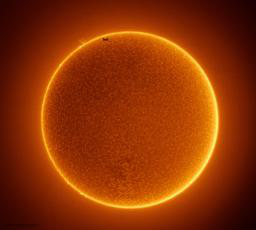

In [2]:
sun_img = Path("sun.jpg")
if not sun_img.exists():
    with DDGS() as ddgs:
        sun_url = next(ddgs.images("sun photo"))["image"]
        download_url(sun_url, sun_img)
    resize_image(sun_img, sun_img.parent, max_size=256)
PILImage.create(sun_img)


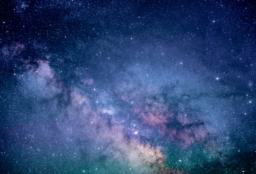

In [3]:

galaxy_img = Path("galaxy.jpg")
if not galaxy_img.exists():
    with DDGS() as ddgs:
        galaxy_url = next(ddgs.images("galaxy photo"))["image"]
        download_url(galaxy_url, galaxy_img)
    resize_image(galaxy_img, galaxy_img.parent, max_size=256)
PILImage.create(galaxy_img)


In [4]:
searches = "sun", "galaxy"
dest_folder = Path("sun_or_not")
dest_folder.mkdir(exist_ok=True)

for s in searches:
    dest_path = dest_folder / s
    if dest_path.exists(): continue

    dest_path.mkdir()
    with DDGS() as ddgs:
        imgs = ddgs.images(f"{s} photo")
        next(imgs) # Skip first since we just got it above
        urls = [next(imgs)["image"] for _ in range(100)]

    download_images(dest_path, urls=urls)
    resize_images(dest_path, max_size=256, dest=dest_path)    

In [5]:
failed = verify_images(get_image_files(dest_folder))
failed.map(Path.unlink)
len(failed)

0

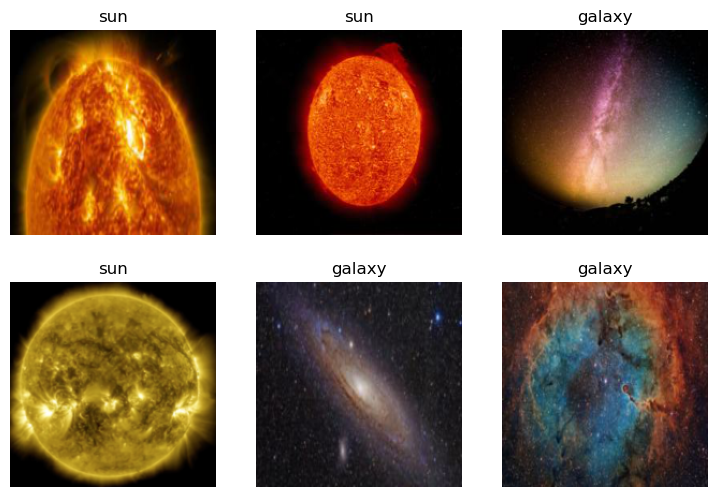

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2),
    item_tfms=Resize(192, "squish")
).dataloaders(dest_folder)
dls.show_batch(max_n=6)

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/nblzv/mambaforge/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nblzv/mambaforge/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.173356,2.376253,0.459459,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.456997,1.519516,0.405405,00:02
1,0.282192,0.620852,0.135135,00:01
2,0.194290,0.387646,0.054054,00:01


In [8]:
learn.predict(PILImage.create(sun_img)), learn.predict(PILImage.create(galaxy_img))

(('sun', tensor(1), tensor([5.6681e-06, 9.9999e-01])),
 ('galaxy', tensor(0), tensor([0.9914, 0.0086])))